# Boosted decision trees and interpretable models

`xgboost` is one of the most popular Machine Learning models (for example, in ML competitions). It isn't based on a model of our neurons, but on a much simpler idea: decision trees.

A decision tree is a tree-like algorithm, i.e. a flowchart with no loops, in which the input data is subdivided in categories according to a series of binary (yes/no) splittings. These splittings are selected by succesively sub-dividing the training data along the boundaries that minimize the number of mis-identified data-points:

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*1FNXYP8CBVRYR9jS7Fy6vA.png)
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*tSkXBEMb8SK9oyUUBqO3dw.png)
![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KxFRvEN57uDTzmA4458eLA.png)


A decision tree becomes a regression tree if each category is associated to a real number.

![](regtree.png)

Thus, a regression tree defines a function $f: \mathbb{R}^n \to \mathbb{R}$. However, this function is rather simple, an can not reproduce arbitrary functions. The solution is to take an *ensemble* of regression trees.

The simplest way to do this is called a *random forest*. In a random forest algorithm, the training data is sampled to train multiple trees (with replacement, so a datapoint can be used to train several trees). Additionally, each tree is allowed to use only a random subset of the features for the splittings, in order to reduce the correlation between trees. The prediction of all the trees of the ensemble is averaged to obtain the prediction of the model.

An improved algorithm is *tree boosting*. Starting with an ensemble with zero trees, it adds at each iteration the tree taht most improves the cost function (*greedy optimization*).

`xgboost` ([arXiv:1603.02754](https://arxiv.org/abs/1603.02754)) is a regularized tree boosting algorithm. "Regularized" means that the cost function is calculated as the sum of two functions: the loss function, that penalizes predictions that are far away from the true values, and the complexity function, that penalizes trees with extreme values of the nodes of the trees.

In [1]:
import xgboost
import pandas as pd
import random

`xgboost` uses a class called `DMatrix` to store the features and labels. A `DMatrix` can be initialized from lists, `numpy`'s arrays, `pandas`' dataframes, etc...

Let us create a class to represent our training and validation data. The following code reads the data from a file into a dataframe, shuffles it and splits it between training and validation, and returns the corresponding `DMatrix`.

In [2]:
class RKDataSet():
    def __init__(self, split=0.8):
        RKdata = pd.read_csv('RKwilson.dat', sep='\t', names=['C9', 'C10', 'RK'])
        self.X = RKdata[['C9', 'C10']]
        self.Y = RKdata['RK']
        self.split = split
        self.idx_tr = range(int(split*len(self)))
        self.idx_val = range(int(split*len(self)), len(self))
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    def train_split(self):
        # Shuffles the data for the training/validation split
        idx = random.sample(range(len(self)), len(self))
        self.idx_tr = idx[:int(self.split*len(self))]
        self.idx_val = idx[int(self.split*len(self)):]
    def train_data(self):
        return xgboost.DMatrix(self.X.loc[self.idx_tr], self.Y.loc[self.idx_tr])
    def val_data(self):
        return xgboost.DMatrix(self.X.loc[self.idx_val], self.Y.loc[self.idx_val])

In [3]:
RKset = RKDataSet()
RKset.train_split()

We can train the `xgboost` model with the function `xgboost.train()`. It takes 3 required arguments: a dictionary with the configuration of the model, the training data and the number of boosting rounds, i.e., the (maximum) number of trees created. Some interesting configuration parameters:
* `nthread`: Number of threads for parallel training.
* `max_depth`: Maximum number of branchings in the trees.
* `device`: The option `'device': 'cuda'` moves the model to a CUDA-capable GPU.
* `objective`: Changes the cost function. The default is `reg:squarederror`, i.e., the minimum squares for regression problems. Other possible options include `reg:logistic`, `reg:absoluteerror` and `reg:poisson`, as well as functions for classification and ranking problems.

In [45]:
xb = xgboost.train({'nthread': 4, 'max_depth': 3}, RKset.train_data(), 50)

We can use the model to make a prediction with the method `predict`. The input data must be in a `DMatrix` with the same format as the training data. In our case, it must be a dataframe with the same headers.

In [8]:
def xb_prediction(C9, C10):
    return xb.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

In [9]:
xb_prediction(-0.87, 0.24)

0.7558299

Optionally, we can visualize the trees using `graphviz`. You need to install `graphviz` both as a python library (e.g. `pip install graphviz`) and as binary for your operating system (e.g. `apt install graphviz`). Let us see the 7th tree in our ensemble:

<Axes: >

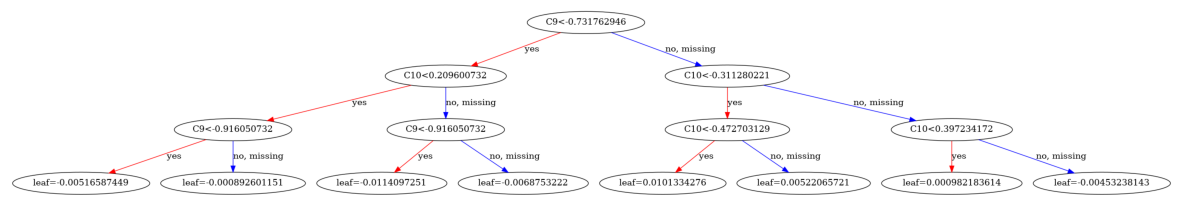

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
xgboost.plot_tree(xb, num_trees=7, ax=ax)

We are at risk of over-fitting if we train too many trees. We can see how the the cost function evolves in the training and validation datasets if we pass them with the argument `evals`. This argument has to be a list of tuples, each tuple containig the corresponding `DMatrix` and a `string` with the name of the dataset:

In [33]:
xb = xgboost.train({'nthread': 4, 'max_depth': 7}, RKset.train_data(), 50, evals=[(RKset.train_data(), 'train'), (RKset.val_data(), 'val')] )

[0]	train-rmse:0.06768	val-rmse:0.06927
[1]	train-rmse:0.04834	val-rmse:0.04990
[2]	train-rmse:0.03464	val-rmse:0.03615
[3]	train-rmse:0.02486	val-rmse:0.02645
[4]	train-rmse:0.01794	val-rmse:0.01950
[5]	train-rmse:0.01302	val-rmse:0.01459
[6]	train-rmse:0.00955	val-rmse:0.01124
[7]	train-rmse:0.00711	val-rmse:0.00894
[8]	train-rmse:0.00542	val-rmse:0.00736
[9]	train-rmse:0.00427	val-rmse:0.00630
[10]	train-rmse:0.00350	val-rmse:0.00558
[11]	train-rmse:0.00296	val-rmse:0.00509
[12]	train-rmse:0.00258	val-rmse:0.00477
[13]	train-rmse:0.00235	val-rmse:0.00456
[14]	train-rmse:0.00218	val-rmse:0.00441
[15]	train-rmse:0.00203	val-rmse:0.00425
[16]	train-rmse:0.00194	val-rmse:0.00415
[17]	train-rmse:0.00189	val-rmse:0.00408
[18]	train-rmse:0.00181	val-rmse:0.00404
[19]	train-rmse:0.00174	val-rmse:0.00400
[20]	train-rmse:0.00171	val-rmse:0.00398
[21]	train-rmse:0.00166	val-rmse:0.00395
[22]	train-rmse:0.00163	val-rmse:0.00394
[23]	train-rmse:0.00158	val-rmse:0.00391
[24]	train-rmse:0.00157	va

We also can store the evaluations in a dictionary with the argument `evals_result`. We can suppress the printing of the evaluations with `verbose_eval=0`:

In [36]:
d_eval = {}
xb = xgboost.train({'nthread': 4, 'max_depth': 7}, RKset.train_data(), 200, evals=[(RKset.train_data(), 'train'), (RKset.val_data(), 'val')], evals_result=d_eval, verbose_eval=0)

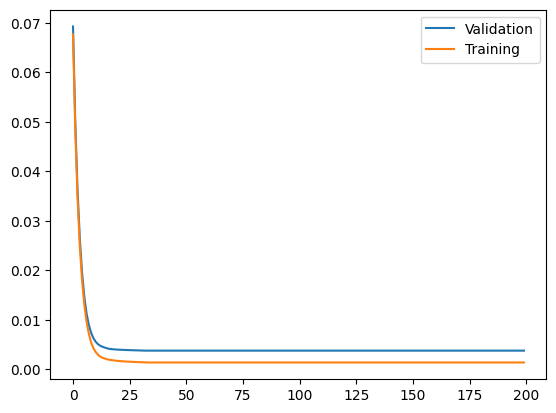

In [37]:
import matplotlib.pyplot as plt

plt.plot(d_eval['val']['rmse'], label='Validation')
plt.plot(d_eval['train']['rmse'], label='Training')
plt.legend()

We see that the cost function at first decreases rapidly, and after that is horizontal. That is, the trees added at later stages don't help in making a better model and we are just overfitting. In order to avoid that, we can use early stopping, that stops the boosting process if the cost function doesn't improve in $n$ rounds. Important: early stopping is based on the *last* dataset passed in `evals`:

In [31]:
d_eval = {}
xb = xgboost.train({'nthread': 4, 'max_depth': 7}, RKset.train_data(), 200, evals=[(RKset.train_data(), 'train'), (RKset.val_data(), 'val')], evals_result=d_eval, verbose_eval=0, early_stopping_rounds=5)

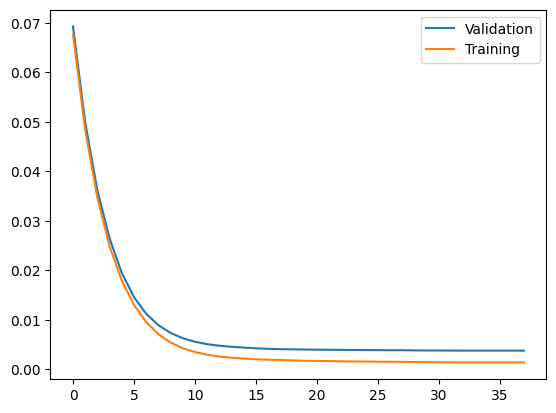

In [32]:
plt.plot(d_eval['val']['rmse'], label='Validation')
plt.plot(d_eval['train']['rmse'], label='Training')
plt.legend()

We can easily create "sub-ensembles" that containing only some of the trees of the original ensemble by slicing it. For example, let us see how the prediction changes if we only use the first five trees, or if we use only the rest:

In [42]:
xb1 = xb[0:5]
def xb1_prediction(C9, C10):
    return xb1.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

xb2 = xb[5:]
def xb2_prediction(C9, C10):
    return xb2.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

In [43]:
print(xb1_prediction(-0.84, 0.3))
print(xb2_prediction(-0.84, 0.3))

0.7735516
0.8702593


We can save the trained model in a `JSON` file:

In [50]:
xb1.save_model("xgboost_model_1.json")

and load from a `JSON`` file:

In [52]:
xb01 = xgboost.Booster(model_file="xgboost_model_1.json")
def xb01_prediction(C9, C10):
    return xb01.predict(xgboost.DMatrix(pd.DataFrame({'C9':[C9], 'C10':[C10]})))[0]

In [53]:
xb01_prediction(-0.84, 0.3)

0.7735516